In [5]:
# PROCESS THE STELLAR CLUSTER CATAOLOG:
# https://arxiv.org/abs/2308.04546
# https://zenodo.org/records/10042028
#
#
# ZACK REEVES
# CREATED: 2023
#
# VERSIONS:
#  1.1  OCT 2023 CREATE JUPYTER NOTEBOOK

In [ ]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas'
metadata['sub_project'] = 'Stellar Clusters'

metadata['catalog'] = 'The Unified Cluster Catalogue: towards a comprehensive and homogeneous data base of stellar clusters (Perren+, 2023)'
metadata['catalog_author'] = 'Perren+'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['catalog_year'] = '2023'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Stellar Clusters'
metadata['data_group_desc'] = 'Stellar Cluster catalog'
metadata['fileroot'] = 'sc'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [34]:
import pandas as pd
import numpy as np
import sys
import collections

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import Angle
from astropy.table import Table

from astroquery.vizier import Vizier

sys.path.insert(0, '..')
from common import file_functions, calculations

import matplotlib.pyplot as plt

In [35]:
#Reading data into Astropy Table

#The catalog is downloaded from https://zenodo.org/records/10042028
#The catalog that should be downloaded to view the 14,000 clusters is UCC_cat.csv.gz, 
#the other catalog is the 1,300,000 stellar members

data = Table.from_pandas(pd.read_csv('UCC_cat.csv.gz'))

In [36]:
#view the data
data

ID,RA_ICRS,DE_ICRS,plx,pmRA,pmDE,UCC_ID,N_50,r_50,RA_ICRS_m,DE_ICRS_m,plx_m,pmRA_m,pmDE_m,Rv_m,N_Rv,C1,C2,C3
str118,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2
Dutra-Bica 58,266.268,-28.848,--,--,--,UCC G000.0+00.1,77.0,8.6,266.274,-28.858,0.429,-0.112,-0.43,-11.754,1.0,0.87,0.6,AB
ESO 456 05;AL 2;Andrews-Lindsay 2;MWSC 2734,268.2709,-29.8888,--,--,--,UCC G000.0-01.8,37.0,6.0,268.23,-29.875,0.362,-0.282,-1.936,23.022,3.0,0.93,1.0,AA
VVV 151;VVV-CL 151,267.8215,-29.6568,--,--,--,UCC G000.0-01.4,0.0,3.1,267.841,-29.652,0.174,-1.905,-4.303,--,0.0,0.31,0.68,CB
DB 1;Dutra-Bica 1,266.7061,-29.0613,--,--,--,UCC G000.0-00.2,0.0,1.8,266.714,-29.057,0.398,-1.338,-2.951,24.157,4.0,0.63,0.28,BC
FSR 0001;MWSC 2622,263.0968,-27.0623,--,--,--,UCC G000.0+03.4,34.0,7.6,263.061,-27.122,0.052,-4.299,-2.589,-52.549,3.0,0.09,0.51,DB
FSR 0002;MWSC 2623,263.1351,-27.0684,--,--,--,UCC G000.0+03.4a,0.0,6.9,263.163,-27.111,0.048,-4.502,-6.769,-0.852,2.0,0.43,0.54,CB
Ryu 152,264.3703,-27.7632,--,--,--,UCC G000.0+02.1,18.0,2.1,264.363,-27.762,0.0,-3.387,-5.077,-79.792,2.0,0.19,0.37,DC
Ryu 537,261.7304,-26.1896,--,--,--,UCC G000.0+04.9,0.0,1.1,261.734,-26.191,0.103,-3.198,-4.489,70.147,2.0,0.42,0.27,CC
Ryu 153,266.5132,-28.8768,--,--,--,UCC G000.1+00.0,55.0,3.3,266.544,-28.87,0.472,-0.795,-2.231,13.288,3.0,0.33,0.36,CC


In [37]:
#setting units and metadata for important columns (ID, RA, DEC, parallax, N_50, r_50)

data['ID'] = data.MaskedColumn(data=data['ID'], 
                               meta = collections.OrderedDict([('ucd', 'meta.id')]),
                               description='Median parallax estimated using the selected members')

data['RA_ICRS_m'] = data.MaskedColumn(data=data['RA_ICRS_m'], 
                                      unit=u.deg,
                                      meta = collections.OrderedDict([('ucd', 'pos.eq.ra')]),
                                      format='{:.6f}', 
                                      description='Median RA estimated using the selected members')

data['DE_ICRS_m'] = data.MaskedColumn(data=data['DE_ICRS_m'], 
                                      unit=u.deg,
                                      meta = collections.OrderedDict([('ucd', 'pos.eq.de')]),
                                      format='{:.6f}', 
                                      description='Median DE estimated using the selected members')

data['plx_m'] = data.MaskedColumn(data=data['plx_m'], 
                                  unit=u.mas,
                                  meta = collections.OrderedDict([('ucd', 'pos.parallax.trig')]),
                                  format='{:.6f}', 
                                  description='Median parallax estimated using the selected members')

data['N_50'] = data.MaskedColumn(data=data['N_50'], 
                                 dtype=int,
                                 meta = collections.OrderedDict([('ucd', 'meta.number')]),
                                 description='Number of estimated members with P>0.5')

data['r_50'] = data.MaskedColumn(data=data['r_50'], 
                                 unit=u.arcmin,
                                 meta = collections.OrderedDict([('ucd', 'phys.ang.size')]),
                                 format='{:.6f}',
                                 description='Radius that contains half the members (in arcmin)')

In [38]:
#Thresh data based on parallax
#some rows have plx_m <= 0 so we start there

data.remove_rows(np.where(data['plx_m']<=0.0)[0])

In [39]:
#calculating distance in light years and parsecs
calculations.get_distance(data, parallax='plx_m', use='parallax')

In [40]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='RA_ICRS_m', dec='DE_ICRS_m')

In [41]:
#playing around with threshing on distance
data.remove_rows(np.where(data['dist_pc']>20000)[0])

<function matplotlib.pyplot.show(close=None, block=None)>

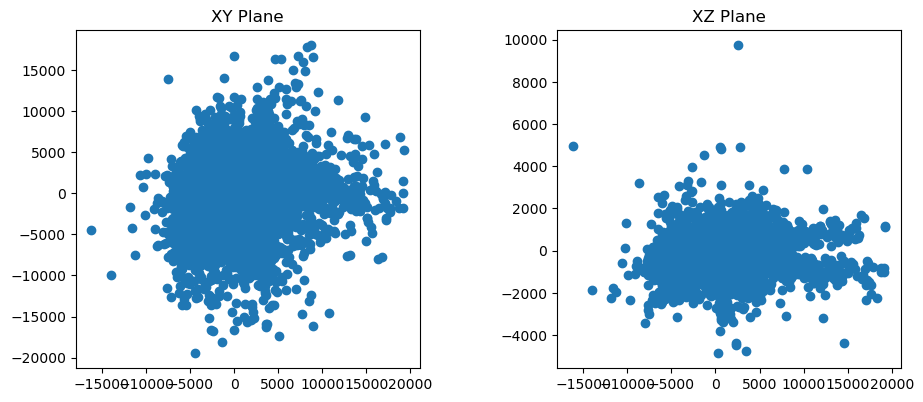

In [42]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [43]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+name for name in data['ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                 description='Object ID')

#construct a label column
data['label'] = data['ID']  #leaving for now in case we want to add other labels

In [44]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'N_50', 'r_50', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
4,N_50,,int32,,,,meta.number,Number of estimated members with P>0.5
5,r_50,arcmin,float64,,6,,phys.ang.size,Radius that contains half the members (in arcmin)
6,speck_label,,str,,,*,meta.id,Object ID


In [45]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [46]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [47]:
file_functions.to_csv(metadata, Table.to_pandas(data), columns)